In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import math
from sklearn.preprocessing import MinMaxScaler
import pywt
from scipy.signal import medfilt

In [2]:
def denoise(data):
    #小波变换
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # 阈值去噪
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # 小波反变换,获取去噪后的信号
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

In [3]:
ours = pd.read_excel("./dataset/BMD101.xlsx", header=None)
ours = ours.iloc[1:, :]
ours = ours.T
ours

,1,2,3,4,5,6,7,8,9,10,...,368623,368624,368625,368626,368627,368628,368629,368630,368631,368632
0,-398,-321,-437,-599,-596,-390,-144,-27,-40,-44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-2072,-2063,-2131,-2198,-2175,-2078,-2029,-2113,-2260,-2336,...,145,144,171,251,330,348,322,322,353,361


In [4]:
# normalization
def norm(X):
    for i in range(X.shape[0]):
        row = X[i, :]
        X[i, :] = (row - row.min())/(row.max()-row.min())
    return

In [5]:
def downsample(signal):
    downsample_signal = []
    signal_array = signal.to_numpy()
    
    for i in range(0,len(signal_array),2):
        downsample_signal.append(signal_array[i])
    
    return downsample_signal

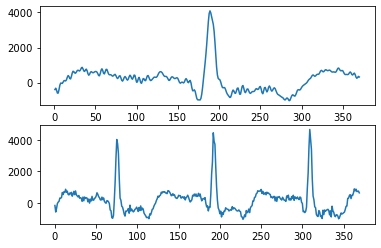

In [26]:
from scipy import signal

s = ours.iloc[0, :]
s = s.dropna()
s = s[0: len(s) - len(s)%5] 
plt.subplot(2, 1, 1)
plt.plot(s[0:370])
down_signal = signal.resample(s, int(len(s)/2.5))
plt.subplot(2, 1, 2)
plt.plot(down_signal[0:370])

In [34]:

def read_our_data(data):
    our_data = []
        
    for i in range(data.shape[0]):
        s = data.iloc[i, :]
        s = s.dropna()
        
        # 500Hz to 200 Hz
        s = s[0: len(s) - len(s)%5]                  # 讓每一筆變成5的倍數，多的捨棄
        down_signal = signal.resample(s, int(len(s)/2.5)) # 每一筆的長度縮短2.5倍，頻率降為200Hz
        ecg_signal = down_signal
        
        # median filter
        filt = int(190*0.8)
        Filter = medfilt(ecg_signal, filt+1)
        signal_filt = ecg_signal - Filter

#         signal_denoise = signal_filt
        
        # wavelet transform
        signal_denoise = denoise(signal_filt)
        
#         print(f'signal_denoise len = {len(signal_denoise)}')
        # splicing data into 370
        for i in range(0,len(signal_denoise), 370):
            if i + 370 >= len(signal_denoise):
                break
            tmp = signal_denoise[i:i+370]
            our_data.append(tmp)

            
    our_data = np.array(our_data)

    return our_data

<h2> Read our data and merged into normal dataset

In [35]:
our_data = read_our_data(ours)

In [52]:
our_data.shape

(729, 370)

In [36]:
covid = pd.read_csv('./dataset/Covid_lead I.csv', header=None)
normal = pd.read_csv('./dataset/Normal_lead I.csv', header=None)
covid = np.array(covid.T)
normal = np.array(normal.T)

In [45]:
from sklearn.model_selection import train_test_split
normal_dataset_train, normal_dataset_test = train_test_split(normal, train_size=0.8, shuffle=True)
our_data_train, our_data_test = train_test_split(our_data, train_size=0.8, shuffle=True)

<h2> Split COVID and NORMAL data for training data & test data

In [41]:
normal_X_train = np.concatenate((normal_dataset_train, our_data_train))
normal_X_test = np.concatenate((normal_dataset_test, our_data_test))
covid_X_train, covid_X_test = train_test_split(covid, train_size=0.8, shuffle=True)

In [42]:
norm(normal_X_train)
norm(normal_X_test)
norm(covid_X_train)
norm(covid_X_test)

In [43]:
for i in range(200):
    noise = 0.05 * np.random.normal(0, 0.1, 370);
    noisySignal = covid_X_train[i] + noise;
    covid_X_train = np.vstack([covid_X_train, noisySignal])
    
    noise2 = 0.05 * np.random.normal(0, 0.2, 370);
    noisySignal2 = covid_X_train[i] + noise2;
    covid_X_train = np.vstack([covid_X_train, noisySignal2])
    
    noise3 = 0.05 * np.random.normal(0, 0.3, 370);
    noisySignal3 = covid_X_train[i] + noise3;
    covid_X_train = np.vstack([covid_X_train, noisySignal3])

In [46]:
normal_X_train.shape, covid_X_train.shape

((743, 370), (800, 370))

In [ ]:
# for i in range(160):
#     noise = 0.05 * np.random.normal(0, 0.1, 370);
#     noisySignal = covid_X_train[i] + noise;
#     covid_X_train = np.vstack([covid_X_train, noisySignal])
    
#     noise2 = 0.05 * np.random.normal(0, 0.2, 370);
#     noisySignal2 = covid_X_train[i] + noise2;
#     covid_X_train = np.vstack([covid_X_train, noisySignal2])
    
#     noise3 = 0.05 * np.random.normal(0, 0.3, 370);
#     noisySignal3 = covid_X_train[i] + noise3;
#     covid_X_train = np.vstack([covid_X_train, noisySignal3])

In [47]:
normal_Y_train = np.zeros(len(normal_X_train))
normal_Y_test = np.zeros(len(normal_X_test))
covid_Y_train = np.ones(len(covid_X_train))
covid_Y_test = np.ones(len(covid_X_test))

In [48]:
X_train = np.concatenate((normal_X_train, covid_X_train))
Y_train = np.concatenate((normal_Y_train, covid_Y_train))
X_test = np.concatenate((normal_X_test, covid_X_test))
Y_test = np.concatenate((normal_Y_test, covid_Y_test))

<h2> make X_data type to 0 ~ 255

In [49]:
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        X_train[i][j] = min(255, int(X_train[i][j]*255))
        
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        X_test[i][j] = min(255, int(X_test[i][j]*255))       

<h2> Get testsamples on board ( 0~ 255 without minus 128 ).

In [50]:
# X_test_board = np.concatenate((X_test[0:25], X_test[6673:6673+25]))
# Y_test_board = np.concatenate((np.zeros(25), np.ones(25)))

<h2> make data to -128 ~ 127

In [20]:
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        X_train[i][j] = X_train[i][j] - 128
        
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        X_test[i][j] = X_test[i][j] - 128

<h2> Suffle

In [51]:
import random
def shuffle_array(X, Y):
    shuffle_index= np.arange(X.shape[0])
    random.shuffle(shuffle_index)
    shuffle_X = X[shuffle_index]
    shuffle_Y = Y[shuffle_index]
    return shuffle_X, shuffle_Y

In [53]:
X_train, Y_train = shuffle_array(X_train, Y_train)

In [54]:
from keras.utils.np_utils import *
Y_train = to_categorical(Y_train, 2)
Y_test = to_categorical(Y_test, 2)
print(Y_train.shape, Y_test.shape)

(1543, 2) (236, 2)


<h2> CNN model

In [55]:
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1],1,1)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1],1,1)

In [56]:
X_test_reshaped.shape, X_train_reshaped.shape

((236, 370, 1, 1), (1543, 370, 1, 1))

In [57]:
# X_test_reshaped = X_test_reshaped.astype(np.uint8)
# X_train_reshaped = X_train_reshaped.astype(np.uint8)

In [58]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint


keras.backend.clear_session()

def build_model():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(3,1), padding='same', activation='relu', input_shape=(370, 1,1)))
    model.add(MaxPooling2D(pool_size=(3,1)))
    model.add(Conv2D(filters=16, kernel_size=(3,1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,1)))
    model.add(Flatten())
    model.add(Dense(4, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_model()

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 370, 1, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 123, 1, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 123, 1, 16)        784       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 41, 1, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 656)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 2628      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

In [60]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_function = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5, min_lr=0.000000001)
callbacks_list = [learning_rate_function]
history = model.fit(X_train_reshaped, Y_train, epochs=70, validation_split=0.2, verbose=1, callbacks=callbacks_list)

Epoch 1/70
39/39 [==============================] - 0s 8ms/step - loss: 0.6701 - accuracy: 0.5956 - val_loss: 0.6189 - val_accuracy: 0.6570
Epoch 2/70
39/39 [==============================] - 0s 5ms/step - loss: 0.5791 - accuracy: 0.7058 - val_loss: 0.5223 - val_accuracy: 0.7864
Epoch 3/70
39/39 [==============================] - 0s 4ms/step - loss: 0.4725 - accuracy: 0.8112 - val_loss: 0.4142 - val_accuracy: 0.8770
Epoch 4/70
39/39 [==============================] - 0s 4ms/step - loss: 0.3958 - accuracy: 0.8817 - val_loss: 0.3758 - val_accuracy: 0.8964
Epoch 5/70
39/39 [==============================] - 0s 4ms/step - loss: 0.3578 - accuracy: 0.9011 - val_loss: 0.3637 - val_accuracy: 0.8997
Epoch 6/70
39/39 [==============================] - 0s 4ms/step - loss: 0.3312 - accuracy: 0.9190 - val_loss: 0.3403 - val_accuracy: 0.9191
Epoch 7/70
39/39 [==============================] - 0s 4ms/step - loss: 0.3049 - accuracy: 0.9279 - val_loss: 0.3112 - val_accuracy: 0.9288
Epoch 8/70
39/39 [==

Epoch 57/70
39/39 [==============================] - 0s 5ms/step - loss: 5.9721e-04 - accuracy: 1.0000 - val_loss: 0.0157 - val_accuracy: 0.9935
Epoch 58/70
39/39 [==============================] - 0s 5ms/step - loss: 5.8459e-04 - accuracy: 1.0000 - val_loss: 0.0150 - val_accuracy: 0.9935
Epoch 59/70
39/39 [==============================] - 0s 4ms/step - loss: 5.8185e-04 - accuracy: 1.0000 - val_loss: 0.0144 - val_accuracy: 0.9935
Epoch 60/70
39/39 [==============================] - 0s 5ms/step - loss: 5.6402e-04 - accuracy: 1.0000 - val_loss: 0.0157 - val_accuracy: 0.9935
Epoch 61/70
27/39 [===================>..........] - ETA: 0s - loss: 5.7942e-04 - accuracy: 1.0000
Epoch 00061: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
39/39 [==============================] - 0s 5ms/step - loss: 5.5866e-04 - accuracy: 1.0000 - val_loss: 0.0149 - val_accuracy: 0.9935
Epoch 62/70
39/39 [==============================] - 0s 4ms/step - loss: 5.4396e-04 - accuracy: 1.0000 - val

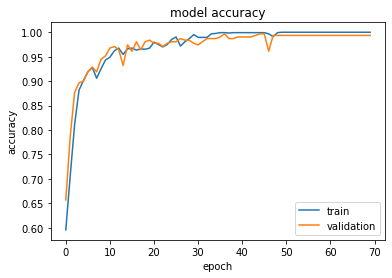

In [61]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

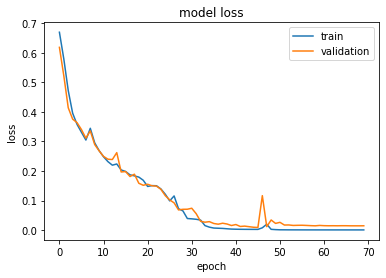

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [63]:
keras.backend.clear_session()
model2 = model
[loss, acc] = model2.evaluate(X_test_reshaped, Y_test, verbose=1)

8/8 [==============================] - 0s 1ms/step - loss: 0.0310 - accuracy: 0.9915


In [64]:
prediction = model2.predict(X_test_reshaped)
classes = np.argmax(prediction, axis=1)
classes

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [65]:
X_test_reshaped.shape

(236, 370, 1, 1)

In [66]:
ans = [int(i) for i in Y_test[:, 1]]

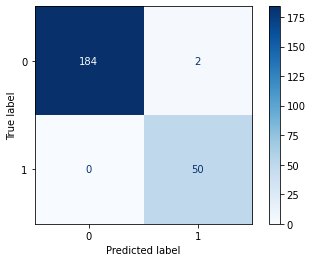

In [67]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(ans, classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

<h1> converted to tflite

In [68]:
model2.save('model_save')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_save\assets


In [69]:
model_test = keras.models.load_model('model_save')

# Model Evaluation
score = model_test.evaluate(X_test_reshaped, Y_test, verbose = 0)
print('test loss', score[0])
print('accuracy', score[1])

test loss 0.03101104311645031
accuracy 0.991525411605835


## Quantization

In [70]:
model = model_test

In [71]:
# tensorflow lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\陳奕帆\AppData\Local\Temp\tmp2sxh6igm\assets


In [72]:
train_data = tf.cast(X_test_reshaped, tf.float32)
# train_data = X_train_reshaped
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_data).batch(1).take(100):
    # Model has only one input so each data point has one element.
        yield [input_value]

In [73]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = representative_data_gen

tflite_model_quant_int8 = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\陳奕帆\AppData\Local\Temp\tmpc2s0xlj8\assets


INFO:tensorflow:Assets written to: C:\Users\陳奕帆\AppData\Local\Temp\tmpc2s0xlj8\assets


In [74]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_int8)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>


In [75]:
import pathlib

tflite_models_dir = pathlib.Path("generated/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_quant_file_int8 = tflite_models_dir/"tflite_model_quant_int8.tflite"
tflite_model_quant_file_int8.write_bytes(tflite_model_quant_int8)

8688

## Evaluate TensorFlow Lite Quant (int8) Model

In [76]:
def evaluate_model(interpreter, X_test, Y_test):
#     X_test_data = tf.cast(X_test, tf.float32)

    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    scale, zero_point = interpreter.get_input_details()[0]['quantization']

    prediction_values = []
    
    i=0
    for test_data in X_test:
#         print('Processing '+str(i)+' data');
        # Pre-processing: add batch dimension, quantize and convert inputs to int8 to match with
        # the model's input data format.
        test_data = np.expand_dims(test_data, axis=0)#.astype(interpreter.get_input_details()[0]["dtype"])
        test_data = np.int8(test_data / scale + zero_point)
        interpreter.set_tensor(input_index, test_data)

        interpreter.invoke()

        # Find the letter with highest probability
        output = interpreter.tensor(output_index)
#         print(output())
        result = np.argmax(output()[0])
        prediction_values.append(result)
        i = i + 1
    
    print(prediction_values)
    accurate_count = 0
    for index in range(len(prediction_values)):
        if prediction_values[index] == Y_test[index]:
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(prediction_values)

    return accuracy * 100

In [77]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file_int8))
interpreter.allocate_tensors()

print(str(evaluate_model(interpreter, X_test_reshaped, Y_test[:,1])) + "%")

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
98.30508474576271%


<h2> Transfer test data to Cpp

In [78]:
# X_test_board.shape, Y_test_board.shape

((25, 370), (50,))

In [79]:
# samples_file = open("generated/test_samples_c.cpp", "w")

# samples_file.write("#include \"test_samples.h\"\n\n")
# samples_file.write("const int kNumSamples = " + str(48) + ";\n\n")

# samples = "" 
# samples_array = "const TestSample_c test_samples_c[kNumSamples] = {"

# for index in range(48):
#     data_arr = list(np.ndarray.flatten(X_test_board[index]))
#     data_arr = [int(i) for i in data_arr]
#     var_name = "sample" + str(index+1) + "c"
#     samples += "TestSample_c " + var_name + " = {\n" #+ "[IMAGE_SIZE] = { "
#     samples += "\t.label = " + str(int(Y_test_board[index])) + ",\n" 
#     samples += "\t.image = {\n"
#     wrapped_arr = [data_arr[i:i + 10] for i in range(0, len(data_arr), 10)]
#     for sub_arr in wrapped_arr:
#         samples += "\t\t" + str(sub_arr)
#     samples += "\t}\n};\n\n"    
#     samples_array += var_name + ", "
    
# samples = samples.replace("[", "")
# samples = samples.replace("]", ",\n")
# samples_array += "};\n"

# samples_file.write(samples);
# samples_file.write(samples_array);
# samples_file.close()

IndexError: index 25 is out of bounds for axis 0 with size 25

In [ ]:
# samples_file = open("generated/test_samples_2.cpp", "w")

# samples_file.write("#include \"test_samples.h\"\n\n")
# samples_file.write("const int kNumSamples = " + str(X_test_reshaped.shape[0]) + ";\n\n")

# samples = "" 
# samples_array = "const TestSample_c test_samples_c[kNumSamples] = {"

# for index in range(X_test_reshaped.shape[0]):
#     data_arr = list(np.ndarray.flatten(X_test_reshaped[index]))
#     data_arr = [int(i) for i in data_arr]
#     var_name = "sample" + str(index+1)
#     samples += "TestSample_c " + var_name + " = {\n" #+ "[IMAGE_SIZE] = { "
#     samples += "\t.label = " + str(int(Y_test[index,1])) + ",\n" 
#     samples += "\t.image = {\n"
#     wrapped_arr = [data_arr[i:i + 10] for i in range(0, len(data_arr), 10)]
#     for sub_arr in wrapped_arr:
#         samples += "\t\t" + str(sub_arr)
#     samples += "\t}\n};\n\n"    
#     samples_array += var_name + ", "
    
# samples = samples.replace("[", "")
# samples = samples.replace("]", ",\n")
# samples_array += "};\n"

# samples_file.write(samples);
# samples_file.write(samples_array);
# samples_file.close()